# Lab 5: Bayesian models
We will first learn a GP regressor for an artificial, non-linear function to illustrate some basic aspects of GPs. To this end, we consider a sinusoidal function from which we sample a dataset. 

In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The function to predict and the dataset we create from it:

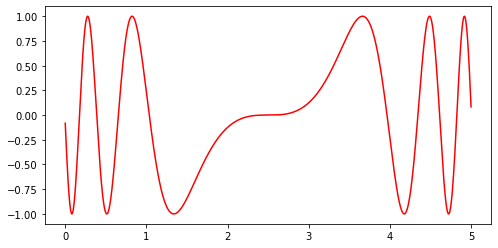

In [2]:
def f(x):
    """The function to predict."""
    return np.sin((x - 2.5) ** 3)

plt.figure(figsize=(8,4))
t = np.linspace(0,5,1000)
plt.plot(t, f(t), 'r', label = 'original f(x)')
plt.show()

The dataset we create based on the function:

In [3]:
# Dataset sampled from a sine function
rng = np.random.RandomState(4)
X_ = rng.uniform(0, 5, 1000)[:, np.newaxis]
y_ = f(X_).ravel()

In [8]:
def plot_gp(g, X_train, y_train, X_full, y_full, y_pred_mean, y_pred_std, use_title="yes"):
    """
    Visualizes the GP predictions, training points and original function
    
    Attributes:
    X_train -- The training data
    y_train -- The correct labels
    X_full -- The data to calculate predictions
    y_full -- The correct labels of the prediction data
    y_pred_mean -- the predicted means
    y_pred_std -- the predicted st. devs.
    """
    x_ = np.linspace(0, 5, 1000)[:,np.newaxis]
    
    idx = np.argsort(X_full[:,0])
    
    # Original function
    a = X_full[idx]
    b = y_full[idx]
    
    plt.figure(figsize=(8,4))
    plt.plot(a, 
             b, 'r', label = 'original f(x)')
    
    # Training points
    plt.scatter(X_train, y_train, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    
    # Prediction 
    d = y_pred_mean[idx]
    e = y_pred_std[idx]
    plt.plot(a, d, 'k', lw=1, zorder=9)
    plt.fill_between(a[:,0], d - 1.96*e, d + 1.96*e, alpha=0.2, color='k')
    
    if use_title == "yes":
        plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (g.kernel_, g.log_marginal_likelihood(g.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

## Exercise 1: visualizing predictions

Train a GP regressor with a RBF kernel with default hyperparameters on a 1% sample of the sine data. Note that by learning a GP the hyperparameters of the chosen kernel are tuned automatically. To visualize what the GP has learned, use the model to predict values for the entire dataset. Plot the original function, the predictions and the training data points. You can use the function `plot_gp()` to assist with plotting.

In [69]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

def train_on_percent(X, y, percent=0.05, n_restarts_optimizer=0, kernel=RBF()):
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=n_restarts_optimizer)
    X_train, _, y_train, _ = train_test_split(X, y, random_state=123, train_size=percent)
    return gpr.fit(X_train, y_train), X_train, y_train

def plot_process(gpr, X_train, y_train, X_full, y_full, use_title="yes"):
    mean, std = gpr.predict(X_full, return_std=True)
    plot_gp(gpr, X_train, y_train, X_full, y_full, mean, std, use_title=use_title)

In [ ]:
gpr = train_on_percent(X_, y_, 0.01)

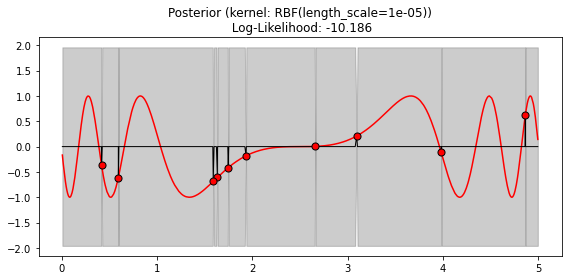

In [13]:
plot_process(*gpr, X_, y_)
# clearly 1% is too little amount of data or badly adjusted hyperparameters

## Exercise 2: reducing the uncertainty
Fit a model using 5% and 10% of the data. Now try setting `n_restarts_optimizer` in the `GaussianProcessRegressor` constructor. Plot the results. What differences do you see?

In [ ]:
gpr = train_on_percent(X_, y_, 0.05)

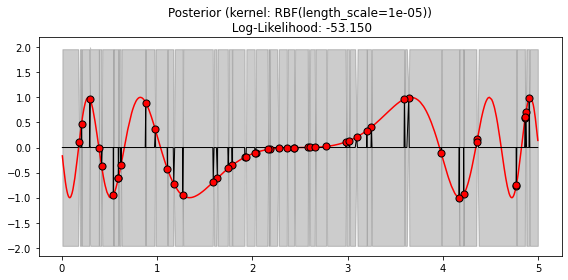

In [11]:
plot_process(*gpr, X_, y_)

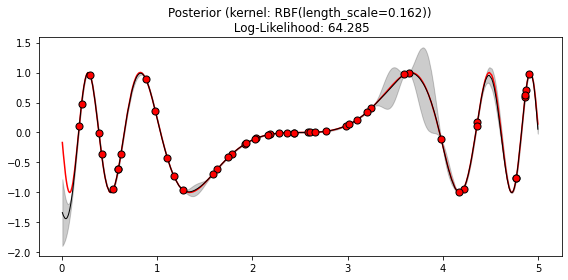

In [17]:
gpr = train_on_percent(X_, y_, 0.05, 5)
plot_process(*gpr, X_, y_)

In [ ]:
gpr = train_on_percent(X_, y_, 0.05, 10)

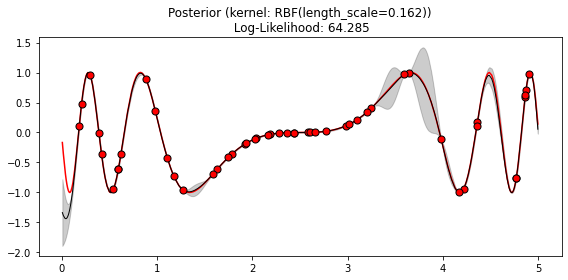

In [32]:
plot_process(*gpr, X_, y_)
# setting number of repeats higher is not helping

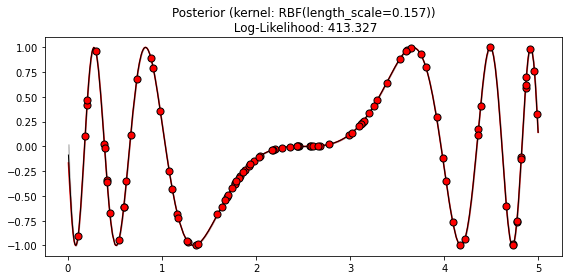

In [34]:
gpr = train_on_percent(X_, y_, 0.1, 5)
plot_process(*gpr, X_, y_)
# almost no uncertainty left

* Only one run can be not sufficient for good results, but 5 or so may be good for the no so complex data.
* As many as 5% or 10% of data is enough to learn the data pretty well(again maybe the function is too simple).

## Exercise 3: Kernels
Like SVMs, kernels play a major role in GPs. Using a 5% sample of the data, train one GP  with each of the following kernels:
    
* RBF
* RationalQuadratic
* ExpSineSquared
* DotProduct
* Matern

What differences do you see in the log-likelihood? Which model fit best the training data?

In [ ]:
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared, DotProduct, Matern

kernels = [RBF(), RationalQuadratic(), ExpSineSquared(), DotProduct(), Matern()]
processes = []

for ker in kernels:
    processes.append(train_on_percent(X_, y_, n_restarts_optimizer=5, kernel=ker))

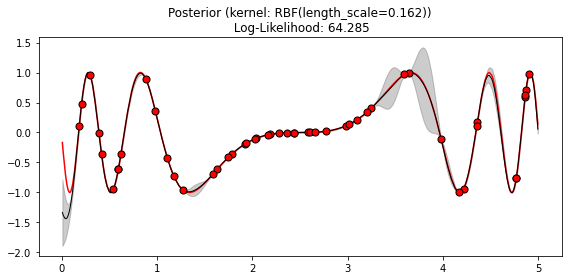

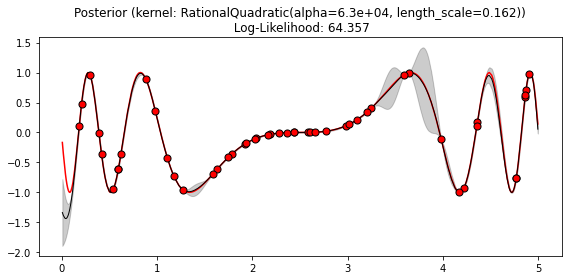

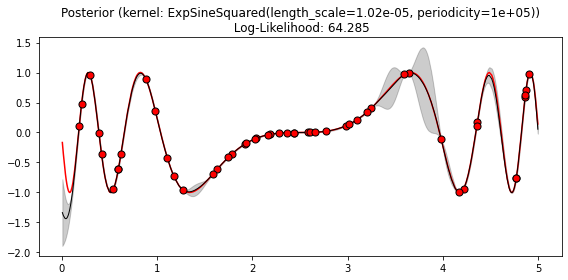

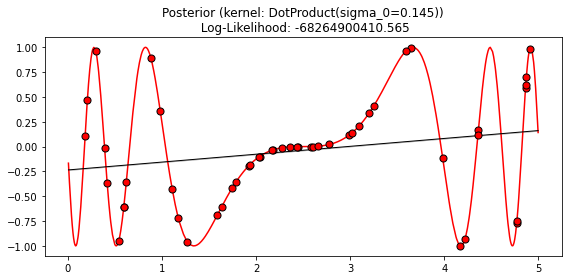

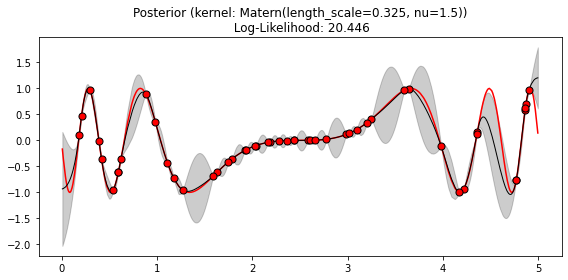

In [36]:
for i in range(5):
    plot_process(*processes[i], X_, y_)
    

plt.show()

* `RBF`, `RationalQuadratic` and `ExpSineSquared` did equally well. `ExpSineSquared` was pretty unstable, which is a weird, as data is periodic. Maybe this is because the data was taken on range which is less than one period and so the ability of `ExpSineSquared` to fit the periodic data was not very useful.
* `Matern` did a bit worse, but still acceptable.
* `DotProduct` is linear and as such completely not suitable for the data.

## Exercise 4: Mauna Loa data
We now look at the problem of predicting the monthly average CO2 concentrations collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2001. This is a time-series data.

In [37]:
from sklearn.datasets import fetch_openml

# originally from sci-kit learn
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187, as_frame=False)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X_mauna, y_mauna = load_mauna_loa_atmospheric_co2()

Quick visualization:

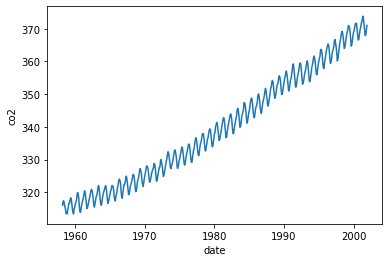

In [39]:
#Quick visualization
plt.plot(X_mauna,y_mauna)
plt.xlabel('date')
plt.ylabel('co2')
plt.show()

## Exercise 4.1
Signals like this usually consist of a combination of different "sub-signals", e.g. a long-term component, a seasonal component, a noise component, and so on. When defining a GP kernel, you can combine multiple kernels, such as:

* A RBF kernel can be used to explain long-term, smooth patterns.
* The seasonal component can be modeled by an `ExpSineSquared` component.
* Small and medium-term irregularities can be modeled by a `RationalQuadratic` component.
* `WhiteNoise` kernel to model white noise.

Train a GP using the first 75% data points as training data using the kernel below. Experiment with removing one or more kernels and check the results visually (you can use `plot_gp`). What do you observe?

In [40]:
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ExpSineSquared, RationalQuadratic

k1 = 50.0**2 * RBF(length_scale=50.0)  # long term smooth rising trend
k2 = 2.0**2 * RBF(length_scale=100.0) \
    * ExpSineSquared(length_scale=1.0, periodicity=1.0,
                     periodicity_bounds="fixed")  # seasonal component
# medium term irregularities
k3 = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
k4 = 0.1**2 * RBF(length_scale=0.1) \
    + WhiteKernel(noise_level=0.1**2,
                  noise_level_bounds=(1e-5, np.inf))  # noise terms

kernel = k1 + k2 +  k3 + k4

In [99]:
import warnings
warnings.filterwarnings('ignore')

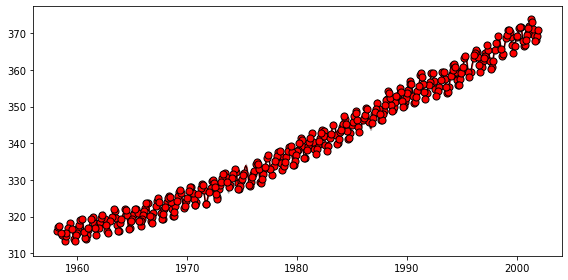

In [104]:
gpr = train_on_percent(X_mauna, y_mauna, percent=0.75, n_restarts_optimizer=0, kernel=kernel)
plot_process(*gpr, X_mauna, y_mauna, "no")

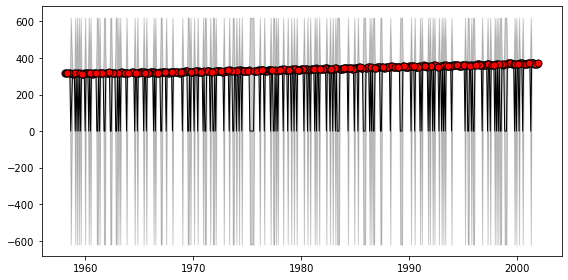

In [103]:
gpr = train_on_percent(X_mauna, y_mauna, percent=0.75, n_restarts_optimizer=0, kernel=k1)
plot_process(*gpr, X_mauna, y_mauna, "no")
# only RBF, does poorly

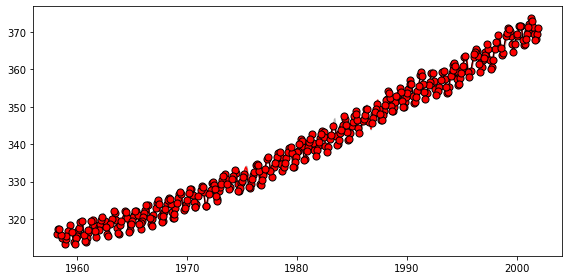

In [102]:
gpr = train_on_percent(X_mauna, y_mauna, percent=0.75, n_restarts_optimizer=0, kernel=k2+k3)
plot_process(*gpr, X_mauna, y_mauna, "no")
# periodic + quadratic, but does ok

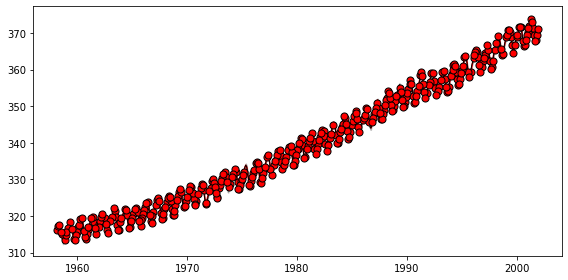

In [106]:
gpr = train_on_percent(X_mauna, y_mauna, percent=0.75, n_restarts_optimizer=0, kernel=k2+k4)
plot_process(*gpr, X_mauna, y_mauna, "no")
# periodic + rbf + noise, does ok

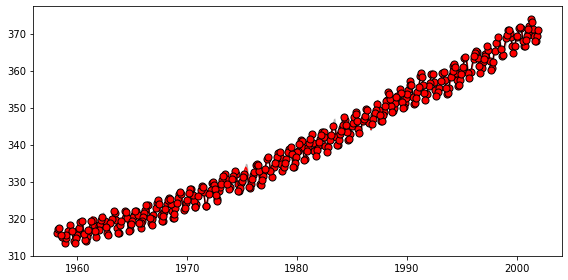

In [108]:
gpr = train_on_percent(X_mauna, y_mauna, percent=0.75, n_restarts_optimizer=0, kernel=k1+k3+k4)
plot_process(*gpr, X_mauna, y_mauna, "no")
# no periodic component, does ok

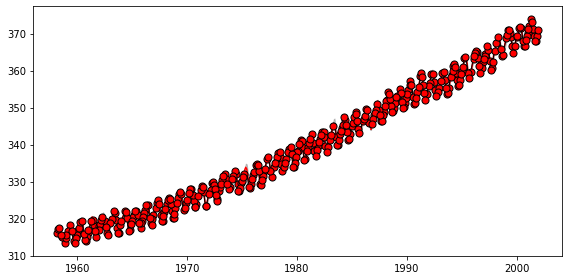

In [110]:
gpr = train_on_percent(X_mauna, y_mauna, percent=0.75, n_restarts_optimizer=0, kernel=k1+k4)
plot_process(*gpr, X_mauna, y_mauna, "no")
# only RBF + white noise, does ok